In [1]:
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#BC371B', '#BC881B', '#4FBC1B'])
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright)

In [3]:
class NeuralNet:
    """
    NN for multi-class classification
    Attributes:
    ...
    """
    
    def __init__(self, neurons_in_layers, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.neurons_in_layers = neurons_in_layers
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s
    
    def __softmax(self, Z):
        eZ = np.exp(Z - np.max(Z))
        return eZ / np.sum(eZ, axis=0, keepdims=True)

    def __initialize_parameters(self):
        neurons_in_layers = self.neurons_in_layers
        parameters = {}
        for i in range(1, len(neurons_in_layers)):
            parameters["W" + str(i)] = np.random.randn(neurons_in_layers[i], neurons_in_layers[i - 1]) * 0.01
            parameters["b" + str(i)] = np.zeros((neurons_in_layers[i], 1))
        self.parameters = parameters
       
    def __forward_propagation(self, X):
        parameters = self.parameters
        caches = []
        A = X
        L = len(parameters) // 2

        for i in range(1, L):
            prev_A = A
            W = parameters["W"+str(i)]
            b = parameters["b"+str(i)]
            
            Z = np.dot(W, prev_A) + b
            linear_cache = (prev_A, W, b)
            
            A = self.__softmax(Z)
            activation_cache = Z
            
            cache = (linear_cache, activation_cache)            
            caches.append(cache)   
            
        W = parameters["W"+str(L)]
        b = parameters["b"+str(L)]
        
        Z = np.dot(W, A) + b
        linear_cache = (A, W, b)
            
        AL = self.__softmax(Z)
        activation_cache = Z
            
        cache = (linear_cache, activation_cache)            
        caches.append(cache)  
        
        assert(AL.shape == (3, X.shape[1]))
        return AL, caches
    
    def compute_cost(self, A, Y):
        J = -np.mean(Y.T * np.log(A.T+ 1e-8))
        return J
        
    def __backward_propagation(self, X, Y, caches):
        grads = {}
        AL = X
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        
        linear_cache, activation_cache = caches[L-1]
        Z = activation_cache
        s = self.__softmax(Z)
        dZ = dAL * s * (1 - s)
        prev_A, W, b = linear_cache
        m = prev_A.shape[1]
        dW = 1 / m * np.dot(dZ, prev_A.T)
        db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prev_dA = np.dot(W.T, dZ)
        
        grads["dA" + str(L-1)] = prev_dA
        grads["dW" + str(L)] = dW
        grads["db" + str(L)] = db
        
        for i in reversed(range(L-1)):
            linear_cache, activation_cache = caches[i]
            Z = activation_cache
            s = self.__softmax(Z)
            dZ = prev_dA * s * (1 - s)
            prev_A, W, b = linear_cache
            m = prev_A.shape[1]
            dW = 1 / m * np.dot(dZ, prev_A.T)
            db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
            prev_dA = np.dot(W.T, dZ)
            
            grads["dA" + str(i)] = prev_dA
            grads["dW" + str(i + 1)] = dW
            grads["db" + str(i + 1)] = db
        return grads
   
    def __update_parameters(self, grads):
        parameters = self.parameters
        learning_rate = self.learning_rate

        for i in range(len(parameters) // 2):
            parameters["W" + str(i+1)] = parameters["W" + str(i+1)] - learning_rate * grads["dW" + str(i+1)]
            parameters["b" + str(i+1)] = parameters["b" + str(i+1)] - learning_rate * grads["db" + str(i+1)]
            
        self.parameters = parameters
        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        self.__initialize_parameters()

        for i in range(0, self.num_iter):
            A, caches = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(A, Y, caches)

            self.__update_parameters(grads)

            if print_cost and i % 100 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 100 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        return np.argmax(positive_probs, axis = 1)

In [4]:
iris = load_iris()
X = iris.data
Y = iris.target

print('Dataset: X={}, y={}'.format(X.shape, Y.shape))

Dataset: X=(150, 4), y=(150,)


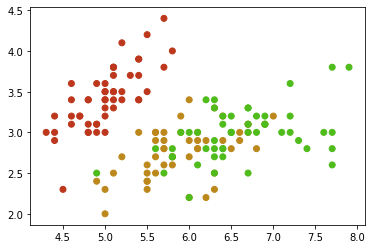

In [5]:
plot_data(X, Y)

In [6]:
cls = NeuralNet(neurons_in_layers = [4, 15, 3], normalize = True, learning_rate = 0.1, num_iter = 2000)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=10)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [8]:
Y_train_transf = np.zeros([len(Y_train), 3])
for i in range(0, len(Y_train)):
    for j in range(0, 3):
        if Y_train[i] == j:
            Y_train_transf[i][j] = 1

Y_train_transf

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1

0-th iteration: 0.36618757212561837
100-th iteration: 0.36548242810662174
200-th iteration: 0.36512074323847293
300-th iteration: 0.36345205112295403
400-th iteration: 0.3533219610218453
500-th iteration: 0.27780906699554353
600-th iteration: 0.2181975061510966
700-th iteration: 0.18867944221411467
800-th iteration: 0.15980387600073448
900-th iteration: 0.13256855959624592
1000-th iteration: 0.11241706553561112
1100-th iteration: 0.09642468687624453
1200-th iteration: 0.08317407607455084
1300-th iteration: 0.07259340649248504
1400-th iteration: 0.06448033529917496
1500-th iteration: 0.05833716424643164
1600-th iteration: 0.053630540933370344
1700-th iteration: 0.049932790276226706
1800-th iteration: 0.04694290798219379
1900-th iteration: 0.04446031231242144


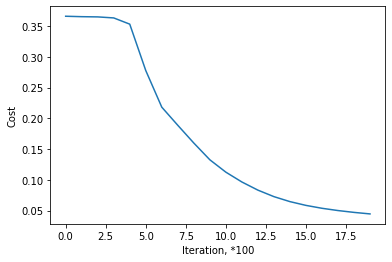

In [9]:
cls.fit(X_train, Y_train_transf)

In [10]:
print(cls.parameters)

{'W1': array([[-1.74546483e-01,  2.43499361e-01, -1.05842610e-01,
        -2.73628735e-01],
       [ 2.60166077e-01, -1.18529141e+00,  8.50814543e-02,
         1.82196735e-01],
       [ 2.90693148e-02, -6.98974291e-02,  2.11619625e-02,
         2.22793825e-02],
       [ 5.51846402e-04, -1.38578717e-01,  1.05705704e-02,
        -3.76244969e-02],
       [-2.46276933e-02, -8.76621190e-02, -2.38268833e-02,
        -5.42824247e-02],
       [ 7.35322091e-02, -1.29760563e-01,  4.10938854e-02,
         8.63803580e-02],
       [ 4.86560818e-03, -1.17779046e-01,  1.24936027e-02,
        -3.19183175e-03],
       [ 1.44939322e-01, -3.20975389e-01,  7.36327064e-02,
         1.61253443e-01],
       [ 1.83284828e-02, -2.54961862e-01,  1.26320846e-02,
         1.21136828e-03],
       [-1.71138760e+00,  4.00440348e-01, -9.62156937e-01,
        -2.07980562e+00],
       [ 7.35947648e-03,  5.24359516e-02,  6.02590177e-03,
        -2.42835887e-04],
       [ 7.71075121e-01, -5.22600507e-01,  4.55054358e-01,

In [11]:
Y_prob = cls.predict_proba(X_train)
Y_prob

array([[0.01811471, 0.88127121, 0.10061408],
       [0.01937024, 0.90631353, 0.07431624],
       [0.01209352, 0.25780153, 0.73010496],
       [0.00281009, 0.02735214, 0.96983777],
       [0.00404024, 0.04736499, 0.94859477],
       [0.98064671, 0.01736799, 0.0019853 ],
       [0.00476622, 0.05868554, 0.93654824],
       [0.00316893, 0.03278538, 0.96404569],
       [0.00272142, 0.02612988, 0.9711487 ],
       [0.00314549, 0.03246461, 0.96438991],
       [0.97966357, 0.0182642 , 0.00207224],
       [0.97885265, 0.01900369, 0.00214366],
       [0.02401591, 0.89591246, 0.08007163],
       [0.90069044, 0.09231163, 0.00699793],
       [0.02593038, 0.82797891, 0.14609071],
       [0.98085037, 0.01718213, 0.0019675 ],
       [0.0204604 , 0.72502223, 0.25451736],
       [0.02013628, 0.42660398, 0.55325974],
       [0.00429613, 0.05044115, 0.94526271],
       [0.00292367, 0.02903352, 0.96804281],
       [0.01650495, 0.5722889 , 0.41120614],
       [0.00325235, 0.03400666, 0.96274099],
       [0.

In [12]:
Y_train_hat = cls.predict(X_train)
Y_train_hat

array([1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 2, 2, 1, 2,
       1, 1, 1, 0, 0, 1, 0, 2, 0, 0, 2, 1, 2, 0, 2, 0, 1, 2, 0, 2, 2, 2,
       2, 1, 0, 1, 2, 1, 0, 2, 1, 1, 0, 0, 0, 1, 2, 2, 1, 0, 0, 0, 2, 2,
       1, 1, 2, 2, 2, 1, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 2, 0, 2, 0, 1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 2, 0, 2, 0,
       0, 1, 0, 2, 2, 2, 1, 0, 2, 0], dtype=int64)

In [13]:
accuracy_score(Y_train, Y_train_hat)

0.95

In [14]:
Y_test_hat = cls.predict(X_test)
Y_test_hat

array([1, 2, 0, 1, 0, 1, 2, 1, 0, 1, 1, 2, 1, 0, 0, 2, 1, 0, 0, 0, 2, 2,
       2, 0, 1, 0, 1, 1, 1, 2], dtype=int64)

In [15]:
accuracy_score(Y_test, Y_test_hat)

0.9666666666666667